# 과제 : Food Inspections in Chicago

시카고 식약청의 담당 공무원 ID(Inspection ID), 영업자 명(DBA Name, AKA Name), 영업자 신고번호(License #), 영업형태(Facility Type), 위험도(Risk), 주소, 점검 일자(Inspection Date), 점검형태(Inspection Type), 점검결과(Results), 위반유형(Violations) 등의 변수를 확인할 수 있다. 우리가 주변에서 볼 수 있는 ‘Subway’와 ‘DUNKIN DONUT’S 가 각각 전체 점검비율의 1%로 상위를 차지하고 있다. 위도와 경도 위치 정보도 있어 지도로 시각화하여 살펴보기에 적합하다. 데이터의 형태도 수치형과 범주형 데이터가 혼재하고 있다.

- 특성변수 후보
      * 과거 5년동안 부적합 이력
      * 최초/마지막 점검 기간
      * 5대호 기준 거리
      * 업체 유형과 부적합 target mean
      * 영업일자(가정)의 WOE

In [1]:
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Imports
import pandas as pd
import numpy as np

import datetime as dt
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

In [2]:
def summary(df) :
    tf = pd.DataFrame({'데이터형태(dtypes)' : df.dtypes,
                       '결측치 수(null)' : df.isnull().sum(),
                       '고유값 수(nunique)' : df.nunique()})
    return tf

# Get Data

In [3]:
# Data import
#df = pd.read_csv("../data/food-inspections.csv")
#df.to_pickle('../data/food-inspections.pkl')
df = pd.read_pickle('../data/food-inspections.pkl')
df.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2352683,CHIPOTLE MEXICAN GRILL,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,Risk 1 (High),1025 W ADDISON ST,CHICAGO,IL,60613.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",NaN,NaN,NaN,NaN,NaN
1,2352734,CHILI'S T-I,CHILI'S (T1-B14),34169.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,...,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",NaN,NaN,NaN,NaN,NaN
2,2352713,NICK'S FIRE GRILL STEAK & LEMONADE INC.,NICK'S FIRE GRILL STEAK & LEMONADE INC.,2699090.0,NaN,Risk 1 (High),2900 W 63RD ST,CHICAGO,IL,60629.0,...,Not Ready,NaN,41.779190,-87.695892,"{'latitude': '-87.69589237398256', 'longitude'...",NaN,NaN,NaN,NaN,NaN


# Data preprocessing & EDA
### 1. Rename column name

In [4]:
df.rename(columns={"License #": "license"}, inplace=True)

### 2. Focus is only on “Canvass” inspections with successful inspections, Pass or Fail

In [5]:
df['Inspection Type'].value_counts(normalize=True).nlargest(5)

Canvass                  0.528365
License                  0.132372
Canvass Re-Inspection    0.105282
Complaint                0.092585
License Re-Inspection    0.045818
Name: Inspection Type, dtype: float64

In [6]:
df = df[df['Inspection Type'].notnull()]
df = df[df['Inspection Type']=='Canvass']

In [7]:
df.Results.value_counts()

Pass                    48877
Fail                    17781
Out of Business         16639
Pass w/ Conditions      15926
No Entry                 4683
Not Ready                  54
Business Not Located       35
Name: Results, dtype: int64

In [8]:
df = df[df.Results.isin(['Pass', 'Fail'])]

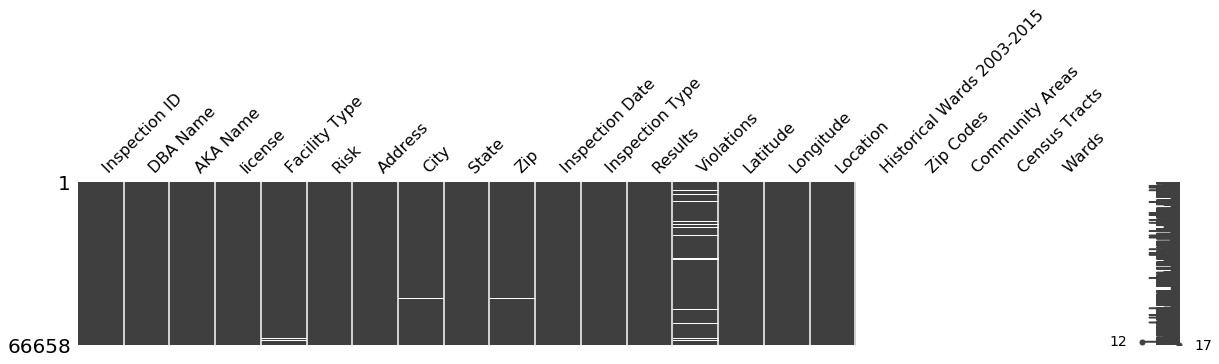

In [9]:
import missingno as msn
msn.matrix(df, figsize=(20,3))

### 3. Drop columns with missing data (>= 60% missing)

Text(0.5, 1.0, 'The percentage of missing values')

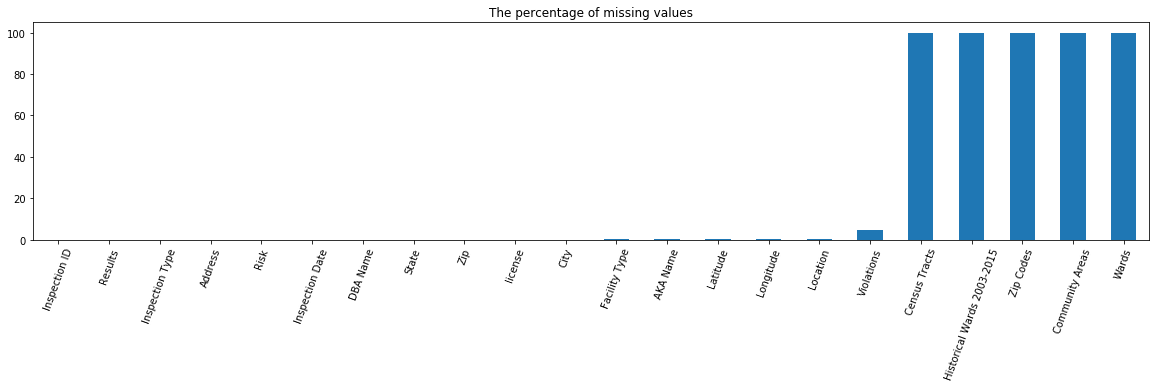

In [10]:
null_percent = df.isnull().mean()*100
null_percent.sort_values().plot.bar(figsize=(20,4), rot='70')
plt.title('The percentage of missing values')

In [11]:
print('결측치 처리 전 df shape : ', df.shape)
null_filtered = null_percent[null_percent > 60].index
df = df.drop(null_filtered, axis =1)
print('결측치 처리 후 df shape : ', df.shape)

결측치 처리 전 df shape :  (66658, 22)
결측치 처리 후 df shape :  (66658, 17)


### 4. Drop redundancy or not necessary or single unique columns

- What is DBA name?
     * In the U.S., a DBA lets the public know who the real owner of a business is. The DBA is also called a fictitious business name or assumed business name. It got its origins as a form of consumer protection, so dishonest business owners couldn't try to avoid legal trouble by operating under a different name.

In [12]:
df.drop(['AKA Name', 'City', 'State', 'Zip', 'Inspection Type', 'Location'], axis=1, inplace=True)

In [13]:
df.dropna(inplace=True)

In [14]:
pd.DataFrame({'자료형태':df.dtypes, '결측치수':df.isnull().sum(), '고유값수':df.nunique()}).sort_values('고유값수')

,자료형태,결측치수,고유값수
Results,object,0,2
Risk,object,0,3
Facility Type,object,0,264
Inspection Date,object,0,2415
Latitude,float64,0,12556
Longitude,float64,0,12556
Address,object,0,12916
DBA Name,object,0,15100
license,float64,0,17916
Violations,object,0,63000


### 5. Quick EDA

Restaurant                      43144
School                           7634
Grocery Store                    6161
Other                            3226
Bakery                           1109
Children's Services Facility      660
Long Term Care                    618
Daycare (2 - 6 Years)             612
Name: Facility Type, dtype: int64

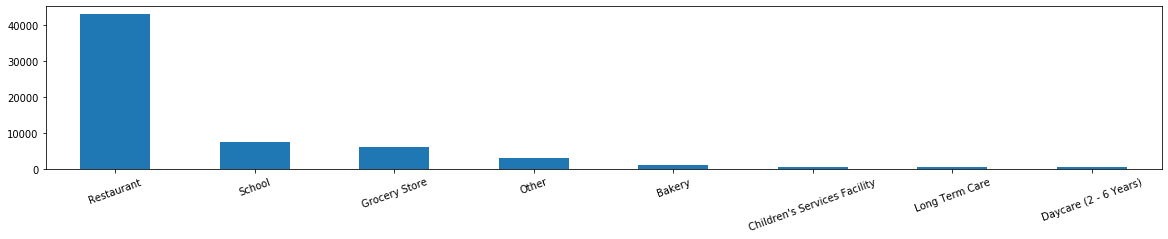

In [15]:
top_seven = df['Facility Type'].value_counts().nlargest(7).index 
df['Facility Type'] = df['Facility Type'].\
where(df['Facility Type'].isin(top_seven), other = "Other")
df['Facility Type'].value_counts()
df['Facility Type'].value_counts().plot(kind='bar', rot = '20', figsize=(20,3))

In [16]:
df['DBA Name'].replace("McDonald's", 'McDonalds', inplace=True)
df['DBA Name'].replace("Chick-fil-A", 'Chick-Fil-A', inplace=True)

Text(0.5, 1.0, 'Top 20 mentioned restaurants')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

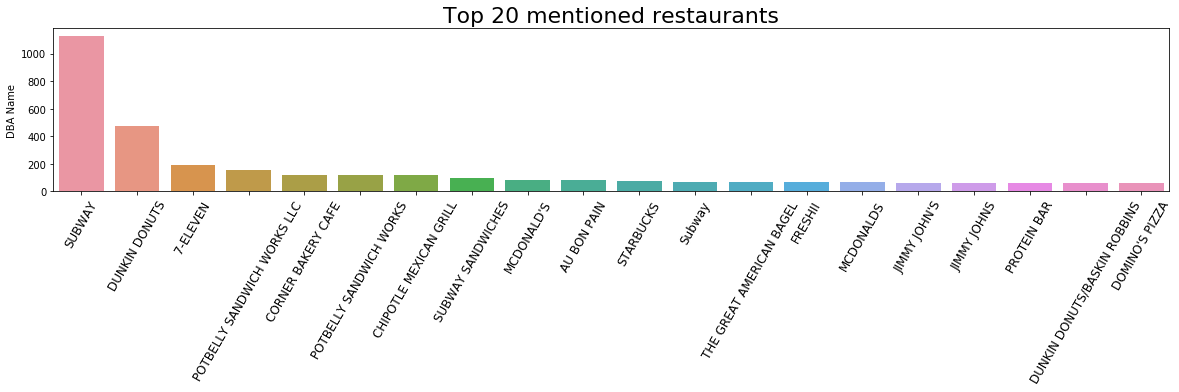

In [17]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20; fig_size[1] = 3
sns.barplot(x=df['DBA Name'].value_counts().index, y=df['DBA Name'].value_counts(),
           order = df['DBA Name'].value_counts().iloc[:20].index)
plt.title('Top 20 mentioned restaurants', fontsize=22)
plt.xticks(rotation=60, fontsize=12)

<Figure size 1080x288 with 0 Axes>

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text xticklabel objects>)

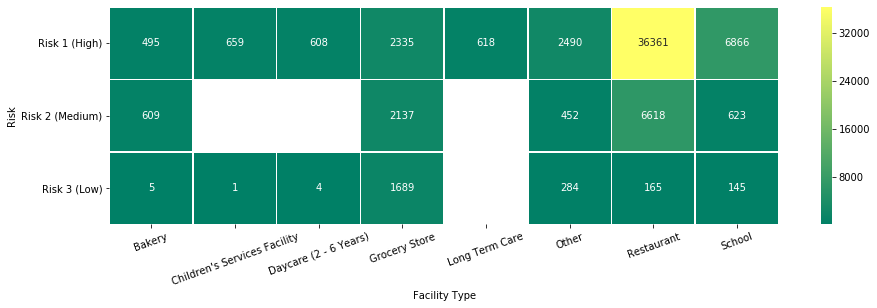

In [18]:
plt.figure(figsize=(15, 4))
data = df.groupby('Risk')['Facility Type'].value_counts().unstack()
sns.heatmap(data=data, annot=True, fmt='.0f', linewidths=.5, cmap='summer')
plt.xticks(rotation=20)

### INSPECTIONS MAP

In [19]:
from folium import folium, plugins

In [20]:
# Find minimum and maximum values for latitude and longitude
la = df['Latitude'].tolist()
lo =df['Longitude'].tolist()

m = folium.Map([min(la), min(lo)], zoom_start=10)
inspections_arr = df.sample(frac=0.3)[["Latitude", "Longitude"]].values  # 20% 데이터만 무작위 추출하여 지도 시각화
m.add_child(plugins.HeatMap(inspections_arr.tolist(), radius=10))

# 시계열분석
- pandas datetimeindex docs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html
- Extract day, month and year from Inspection Date column

### 1. 시계열 데이터 전환

In [21]:
df['Date'] = pd.to_datetime(df['Inspection Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('2010-01-04 00:00:00'), Timestamp('2019-12-04 00:00:00'))

### 2. Extract day, month and year from 'Date'  columns

In [22]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

<Figure size 1080x288 with 0 Axes>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]), <a list of 12 Text xticklabel objects>)

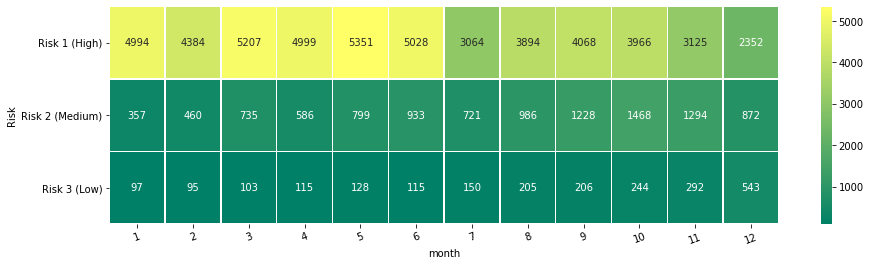

In [23]:
plt.figure(figsize=(15, 4))
data = df.groupby('Risk')['month'].value_counts().unstack()
sns.heatmap(data=data, annot=True, fmt='.0f', linewidths=.5, cmap='summer')
plt.xticks(rotation=20)

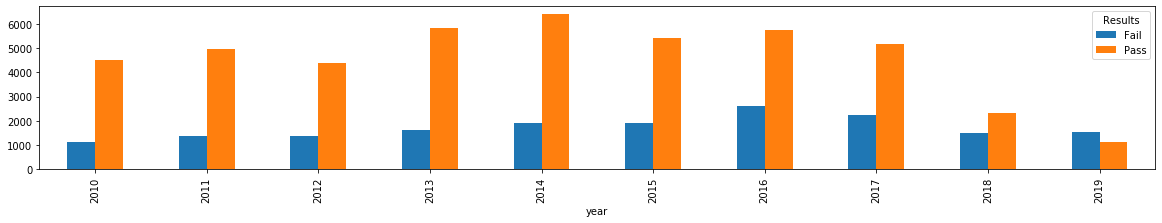

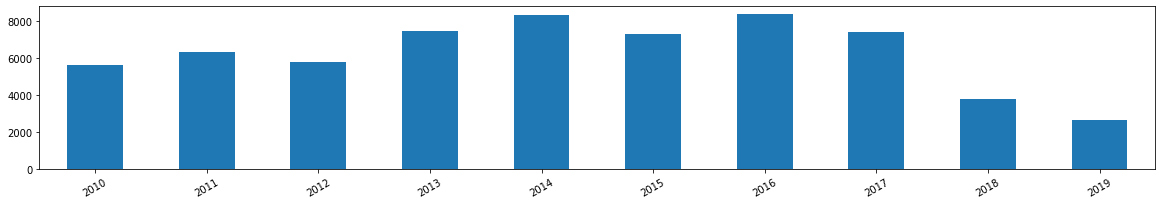

In [24]:
df.groupby('year').Results.value_counts().unstack().plot.bar(figsize=(20,3)); plt.show()
df['Date'].dt.year.value_counts().sort_index().plot(kind= 'bar',rot='30', figsize=(20,3))

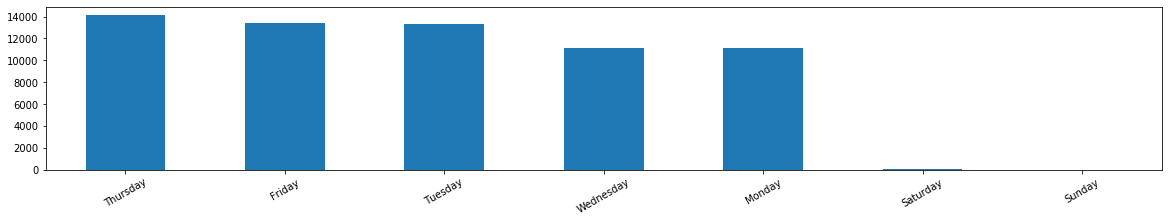

In [25]:
df['Date'].apply(lambda x: x.date().strftime('%A')).value_counts().plot(kind='bar',rot='30',figsize=(20,3))

### 3. 점검회수와 위반회수를 추출하기 위해 두개의 컬럼을 만들어 이동평균(window) 확인

In [26]:
df['점검'] = 1
df['위반'] = 0
df.loc[df['Results']== 'Fail', '위반'] = 1

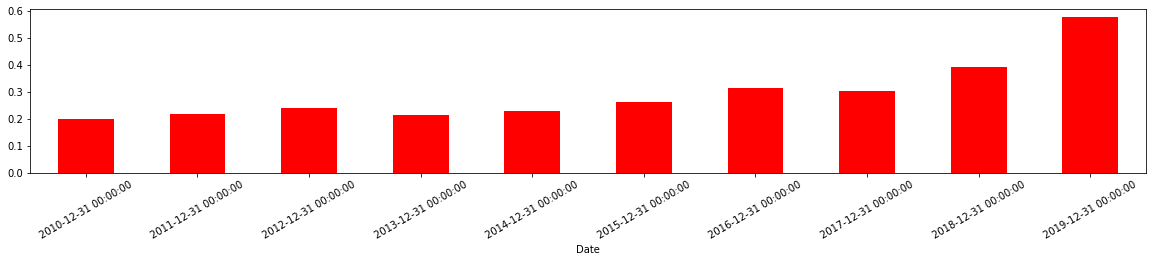

In [27]:
tf = df.set_index('Date')
tf['위반'].resample(rule='Y').mean().plot(kind='bar', rot='30', figsize=(20,3), color='red')

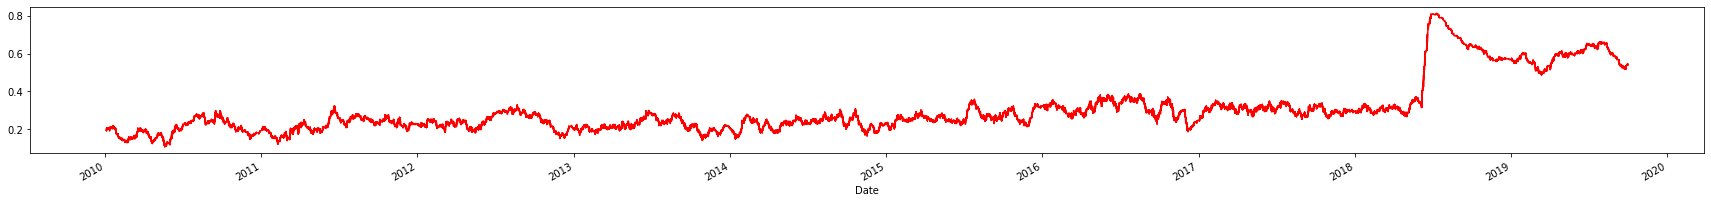

In [28]:
rolling = tf['위반'].rolling(window=365)
rolling.mean().plot(figsize=(30,3), color='red')

### 4. 최초와 최종 점검일 기간, 해당기간(영업기간) 동안 위반건수

In [29]:
print('The numbers of nan, inf & -inf : ', df.isin([np.nan, np.inf, -np.inf]).any(1).sum())

The numbers of nan, inf & -inf :  0


In [30]:
latest_data = df.sort_values('Inspection Date', ascending = False).groupby('DBA Name').head(1)
first_data = df.sort_values('Inspection Date', ascending = True).groupby('DBA Name').head(1)

len(set(latest_data['DBA Name'].unique()) & set(first_data['DBA Name'].unique()))

15099

In [31]:
data = latest_data[['DBA Name', 'Date']].merge(first_data[['DBA Name', 'Date']], on = 'DBA Name', suffixes=('_latest', '_first'))
data['영업일수'] = data['Date_latest'] - data['Date_first']
data = data.merge(df.groupby('DBA Name')['위반'].sum().reset_index(name="위반건수"), on = 'DBA Name')
data.head()

,DBA Name,Date_latest,Date_first,영업일수,위반건수
0,CHILI'S T-I,2019-12-04,2011-08-17,3031 days,2
1,JAMIESON,2019-12-04,2010-04-22,3513 days,5
2,HARRY CARAY'S SHORTSTOP,2019-12-03,2019-12-03,0 days,0
3,SUTHERLANDS,2019-12-03,2012-04-26,2777 days,2
4,AMARIT RESTAURANT,2019-12-03,2010-04-16,3518 days,6


In [32]:
df = df.merge(data[['DBA Name', '영업일수']], on = 'DBA Name')
df['영업일수'] = df['영업일수'].dt.days

### 5. High risk임에도 적합판정 결과의 절대값이 크다
- Risk에 따른 odd ratio를 3등급 구분하여 변수로 반영

In [33]:
df.groupby(['Risk', 'Results']).size().reset_index(name="Frequency") # multi index를 columns으로 변환

,Risk,Results,Frequency
0,Risk 1 (High),Fail,13889
1,Risk 1 (High),Pass,36543
2,Risk 2 (Medium),Fail,2666
3,Risk 2 (Medium),Pass,7773
4,Risk 3 (Low),Fail,697
5,Risk 3 (Low),Pass,1596


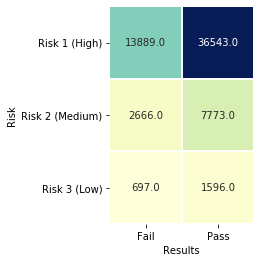

In [34]:
fig, ax = plt.subplots(figsize=(10,4))
sns.heatmap(pd.crosstab([df.Risk], [df.Results]),
            cmap="YlGnBu", annot=True, fmt=".1f", linewidths=1.0, square=1, cbar=False)

### Restaurant인지 아닌지 dummy 변수 설정
- Add new feature called Restaurant that describe if the Facility Type is restaurant or not
- high risk (more than 50%)에 대부분 데이터가 분포하고 'low risk'에는 'restaurant'비중이 아주 낮음

In [35]:
df['Restaurant'] = (df['Facility Type'].values == 'Restaurant').astype('int')

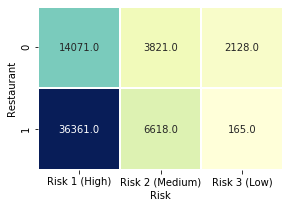

In [36]:
sns.heatmap(pd.crosstab([df.Restaurant], [df.Risk]),
            cmap="YlGnBu", annot=True, fmt=".1f", linewidths=1.0, square=1, cbar=False)

# 과거 점검이력 (Inspection history)
### 1. 과거 부적합이력 확인(odds ratio)
- 최근의 부적합 판정 이력이 부적합에 가장 영향을 많이 미침
- 점검일자를 기준으로 오름차순 정리하고 
- 'license'로 그룹핑한하여 직전의 점검결과(shift())를 'previous_results' 컬럼으로 생성

In [37]:
# Sort inspections by date
df = df.sort_values(by="Inspection Date")

# Only consider inspections with clear results
df = df.loc[df.Results.isin(["Pass", "Fail"])]

# Group inspections by license and shift 1 to find previous results
df["previous_results"] = df.groupby(by="license").shift().Results

# Calculate cross tabulation of results and previous results
chart = pd.crosstab(df.previous_results, df.Results)

# Make Numpy array of total counts of prior fails and passes with the 
# following(post) results
chart_arr = np.array(chart)
chart_arr

array([[ 4254,  6475],
       [ 8137, 26382]], dtype=int64)

In [38]:
# Create new dataframe from Numpy array to clearly dispay prior and 
# post results
pass_fail_chart = pd.DataFrame({"Prior Fail":chart_arr[:,0],
                                "Prior Pass":chart_arr[:,1]})
pass_fail_chart.index = pass_fail_chart.index.rename("")
pass_fail_chart = pass_fail_chart.rename(index={0:"Post Fail",1:"Post Pass"})

# Display chart
pass_fail_chart

,Prior Fail,Prior Pass
,,
Post Fail,4254,6475
Post Pass,8137,26382


### (1) post fails 결과에서 prior fails 비율

In [39]:
pass_fail_chart.loc["Post Fail", "Prior Fail"] 
pass_fail_chart.loc["Post Fail", :].sum()
fail_fail_probability = (pass_fail_chart.loc["Post Fail", "Prior Fail"] /
                         pass_fail_chart.loc["Post Fail", :].sum())

print(str(100*fail_fail_probability) + " of prior fails resulted in a subsequent fail")

4254

10729

39.649547954142975 of prior fails resulted in a subsequent fail


### (2) post fails 결과에서 prior passes 비율

In [40]:
pass_fail_probability = (pass_fail_chart.loc["Post Pass", "Prior Fail"] /
                         pass_fail_chart.loc["Post Pass", :].sum())

print(str(100*pass_fail_probability)+ " of prior passes resulted in a subsequent fail")

23.572525275934993 of prior passes resulted in a subsequent fail


### odds ratio (2)/(1) pass/fail probability vs fail/fail probability

In [41]:
print(str(100*(1 - (pass_fail_probability / fail_fail_probability))) +" more likely that a prior fail will predict a subsequent fail than a prior pass")

40.547808254464854 more likely that a prior fail will predict a subsequent fail than a prior pass


- 최근에 부적합 판정 받은 업체의 부적합 확률은 적합판정 받은 업체보다 거의 2배가까이 높다(odd ratio)

# 지리적 정보 반영(공간정보)

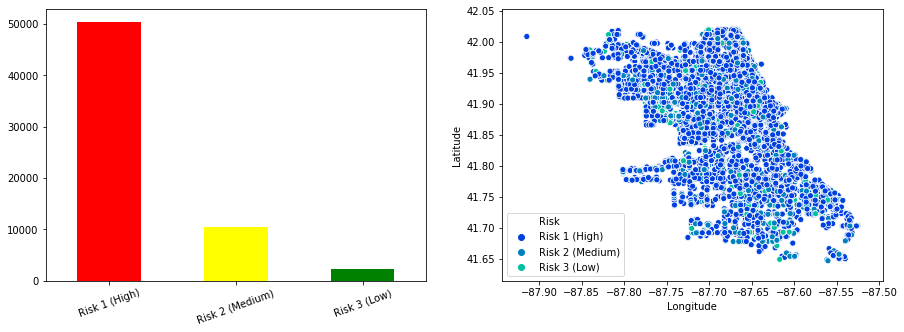

In [42]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
df.Risk.value_counts().plot(kind='bar', rot='20', 
                            color=['red','yellow','green', 'blue'], ax=ax[0])

sns.scatterplot(x='Longitude', y='Latitude', hue='Risk', 
                palette='winter', data=df.sample(frac=0.5))

## 위도 경도 표준화 for 해안가로 부터거리 등급 부여

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df['Latitude'][:, np.newaxis]) # 컬럼벡터로 변환
df['Latitude'] = scaler.transform(df['Latitude'][:, np.newaxis])
scaler.fit(df['Longitude'][:, np.newaxis]) # 컬럼벡터로 변환
df['Longitude'] = scaler.transform(df['Longitude'][:, np.newaxis])

df['far']=df['Latitude']*0.4 + df['Longitude'] # 위도(latitude) 경도(longitude)
df['far_q'] = pd.qcut(df['far'], q = 5, labels = np.arange(5)) 

MinMaxScaler()

MinMaxScaler()

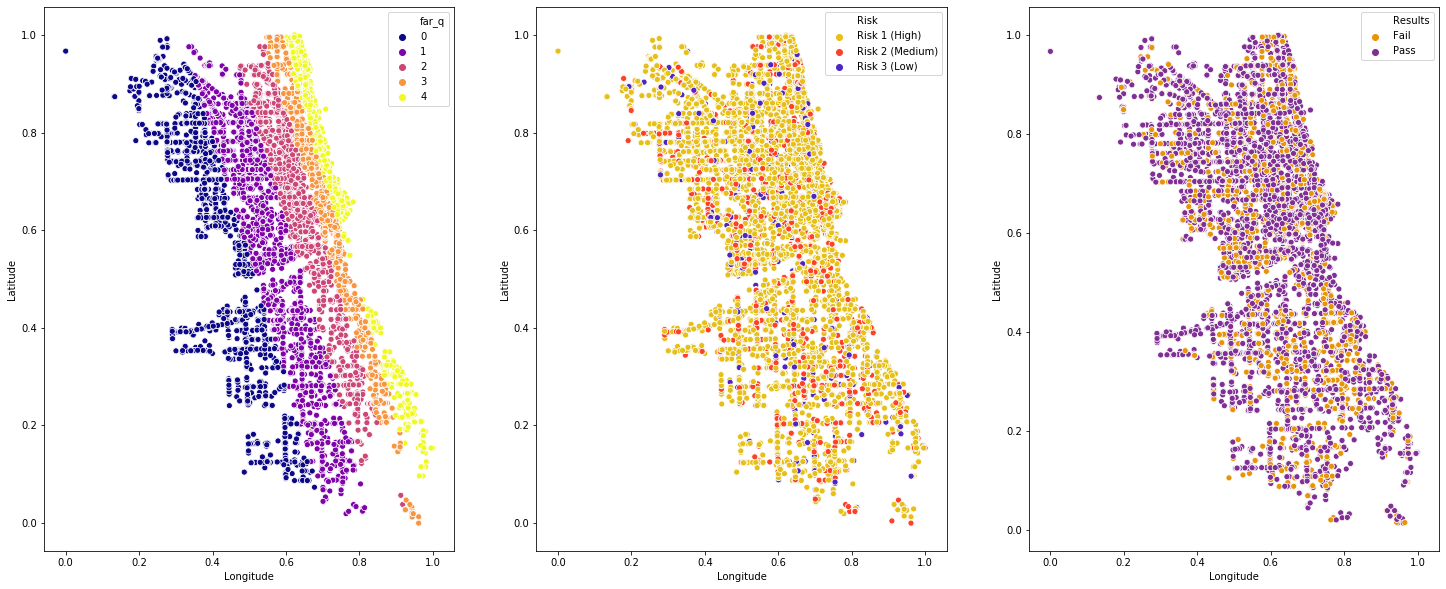

In [44]:
fig,ax=plt.subplots(1,3,figsize=(25,10))
sns.scatterplot(x='Longitude', y='Latitude', hue='far_q', palette='plasma', legend='full', data=df.sample(frac=0.3), ax=ax[0]) 
sns.scatterplot(x='Longitude', y='Latitude', hue='Risk', palette='CMRmap_r', legend='full', data=df.sample(frac=0.3), ax=ax[1])   
sns.scatterplot(x='Longitude', y='Latitude', hue='Results', palette='CMRmap_r', legend='full', data=df.sample(frac=0.3))   

In [45]:
df['far_q'] = df['far_q'].astype('int')

In [46]:
map_dict = {'Risk 1 (High)':3, 'Risk 2 (Medium)':2, 'Risk 3 (Low)':1}
df['Risk'] = df['Risk'].map(map_dict)

In [47]:
df['Results'].replace({'Pass':0, 'Fail':1}, inplace=True)

Text(0.5, 1, 'Fail ratios between month & year')

Text(0.5, 1, 'Risk ranks between year & off shore distance')

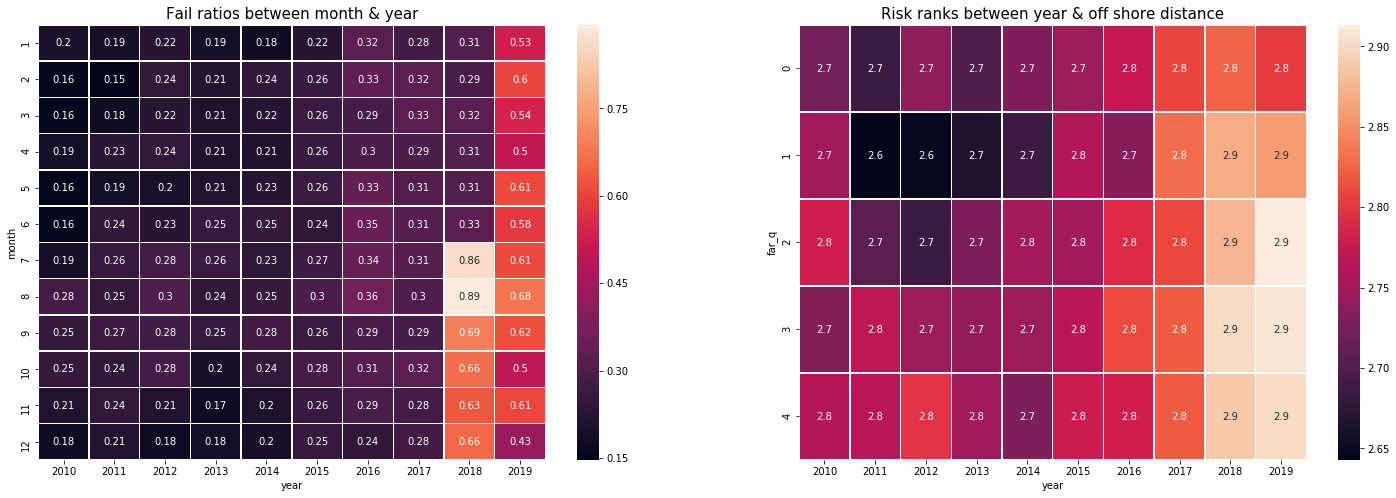

In [48]:
fig,ax=plt.subplots(1,2,figsize=(25,8)) 
tf = pd.pivot_table(df, index='month',columns='year', values='Results')
sns.heatmap(tf, annot=True, linewidths=.5,  ax=ax[0])
ax[0].set_title('Fail ratios between month & year',size=15)
af = pd.pivot_table(df, index='far_q',columns='year', values='Risk')
sns.heatmap(af, annot=True, linewidths=.5,  ax=ax[1])
ax[1].set_title('Risk ranks between year & off shore distance',size=15)

# 기후와 강수량 외부 정보와 연계
https://www.timeanddate.com/weather/usa/chicago/climate  

- Web crawling

# 과거 부적합이력 파생변수 생성(시간정보)
## 영업자와 연도별 기준으로 과거 5년동안의 점검 위반이력을 컬럼으로 생성 데이터셋 구성

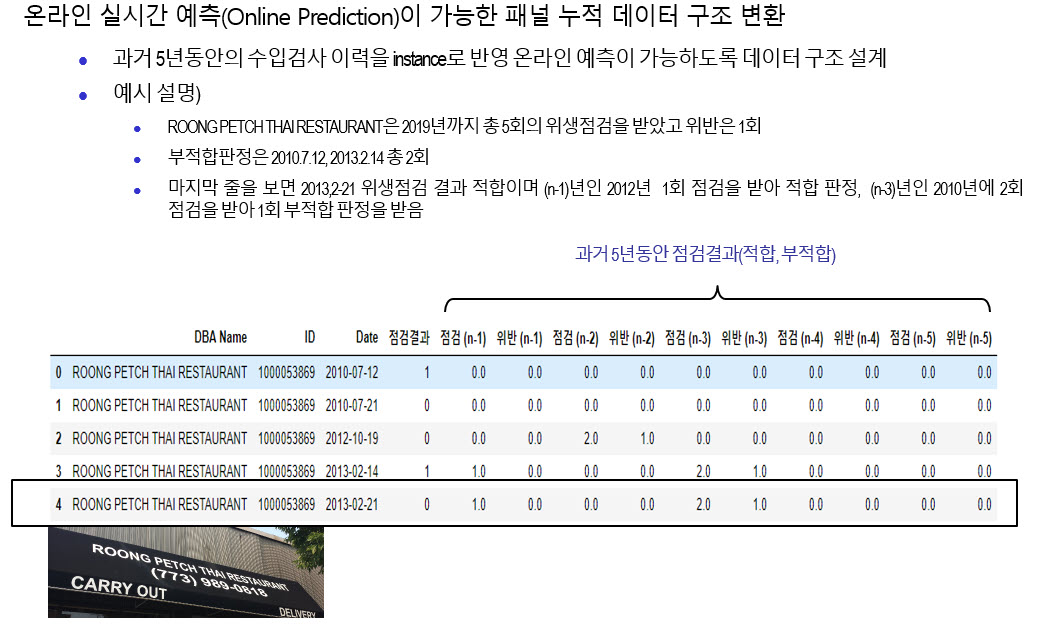

In [49]:
from IPython.display import Image
Image(filename='../image/pandas/chicago.jpg', width=800, height=600)

## step 1 - 영업자의 년도별 누적단속 현황(중복 Inspection ID 제거)

In [50]:
df.shape
df[df.duplicated('Inspection ID')].shape
df = df[~df.duplicated('Inspection ID')]
df.shape

(63164, 22)

(51, 22)

(63113, 22)

In [51]:
df = df.rename(columns={'Inspection ID': 'ID'})

In [52]:
df20 = df.groupby(['DBA Name', 'year']).agg({'점검':['sum'], '위반':['sum']})
df20.columns = ['점검', '위반']
df20 = df20.reset_index()
df20.head()

,DBA Name,year,점검,위반
0,"#1 CHINA EXPRESS, LTD.",2010,1,0
1,#1 CHOP SUEY,2010,1,0
2,#1 CHOP SUEY,2011,1,0
3,#1 CHOP SUEY,2012,1,0
4,#1 CHOP SUEY,2013,2,1


## step 2 - 영업자의 과거 10년 가상 단속이력

In [53]:
from itertools import product
df30 = pd.DataFrame(product(df['DBA Name'].unique(), df['year'].unique()), 
                    columns=['DBA Name','year'])
df30 .head(13)

,DBA Name,year
0,TEMPO CAFE,2010
1,TEMPO CAFE,2011
2,TEMPO CAFE,2012
3,TEMPO CAFE,2013
4,TEMPO CAFE,2014
5,TEMPO CAFE,2015
6,TEMPO CAFE,2016
7,TEMPO CAFE,2017
8,TEMPO CAFE,2018
9,TEMPO CAFE,2019


## step 3 - step2 + step3 # 가능한 모든 조합에 점검결과를merge

In [54]:
df31 = (df30.merge(df20, how='left').sort_values(['DBA Name','year']).reset_index(drop=True))

# 과거 5년간의 점검 위반 회수를 df에 생성, 점검이 없던 해(그 해 기준으로 과거 5년간의 점검 위반값을 알 수 있도록)도 데이터 생성됨
df32 = pd.DataFrame()
lags = range(1, 6)
#df31_grouped = df31.groupby(['ID'])
cols = ['점검', '위반']
for n in lags: 
    for col in cols:
        df32[f'{col} (t-{n})'] = df31.groupby(['DBA Name'])[f'{col}'].shift(n)
df_A = df31.merge(df32, left_index=True, right_index=True)
df_A.head()

,DBA Name,year,점검,위반,점검 (t-1),위반 (t-1),점검 (t-2),위반 (t-2),점검 (t-3),위반 (t-3),점검 (t-4),위반 (t-4),점검 (t-5),위반 (t-5)
0,"#1 CHINA EXPRESS, LTD.",2010,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"#1 CHINA EXPRESS, LTD.",2011,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"#1 CHINA EXPRESS, LTD.",2012,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,"#1 CHINA EXPRESS, LTD.",2013,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN
4,"#1 CHINA EXPRESS, LTD.",2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN


## step 4 - 영업자와 년도별 과거 누적 점검 및 위반 현황
영업자와 연도별 기준으로 올해 및 해당년도(5년동안)의 점검 누적결과 생성

In [55]:
df41 = df.sort_values(['DBA Name','Date']).reset_index(drop=True)
df42 = df41.groupby(['DBA Name','year']).agg({'점검':'cumsum', '위반':'cumsum'})
df43 = df41.merge(df42, left_index=True, right_index=True)
# 이번을 제외한 올해의 누적 점검횟수 위반횟수 계산
df43['점검_y'] = df43['점검_y'] - df43['점검_x']
df43['위반_y'] = df43['위반_y'] - df43['위반_x']
# df43['점검_x']은 모두 1이므로 제거
del df43['점검_x']
# 점검결과 1 --> 위반으로 설정
df_B = df43.rename(columns={'점검_y':'점검', '위반_y':'위반', '위반_x':'점검결과'})

In [56]:
df = df_B.merge(df_A, on=['DBA Name', 'year'])
del df['점검_y']; del df['위반_y']

### 과거 점검이력 nan은 점검을 하지않은 것이므로 '0'로 imputation

In [57]:
# Impute checklist with 'zero'
check = ['점검 (t-1)', '위반 (t-1)', '점검 (t-2)', '위반 (t-2)', '점검 (t-3)',
         '위반 (t-3)', '점검 (t-4)', '위반 (t-4)', '점검 (t-5)', '위반 (t-5)']
for i in check :
    df[i]= df[i].fillna(0)
df[check]

,점검 (t-1),위반 (t-1),점검 (t-2),위반 (t-2),점검 (t-3),위반 (t-3),점검 (t-4),위반 (t-4),점검 (t-5),위반 (t-5)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
63108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63110,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63111,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# object는 category 변환
for col in df.columns :
    if df[col].dtypes == 'object' :
        df[col] = df[col].astype('category')
df.rename(columns={'점검_x': '점검', '위반_x': '위반'}, inplace = True)

In [59]:
df.columns

Index(['ID', 'DBA Name', 'license', 'Facility Type', 'Risk', 'Address',
       'Inspection Date', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Date', 'year', 'month', 'day', '점검결과', '영업일수', 'Restaurant',
       'previous_results', 'far', 'far_q', '점검', '위반', '점검 (t-1)', '위반 (t-1)',
       '점검 (t-2)', '위반 (t-2)', '점검 (t-3)', '위반 (t-3)', '점검 (t-4)', '위반 (t-4)',
       '점검 (t-5)', '위반 (t-5)'],
      dtype='object')

## 년도별 점검과 점검 결과가 시계열 변수처럼 반영이 되었는지 확인

In [60]:
df.loc[df['DBA Name'] == "MC DONALD'S", :][['DBA Name', 'Date', 'year', 'month', '점검결과', '점검', '위반',  '점검 (t-1)', '위반 (t-1)',
       '점검 (t-2)', '위반 (t-2)', '점검 (t-3)', '위반 (t-3)', '점검 (t-4)', '위반 (t-4)',
       '점검 (t-5)', '위반 (t-5)']].sort_values('Date')

,DBA Name,Date,year,month,점검결과,점검,위반,점검 (t-1),위반 (t-1),점검 (t-2),위반 (t-2),점검 (t-3),위반 (t-3),점검 (t-4),위반 (t-4),점검 (t-5),위반 (t-5)
34628,MC DONALD'S,2010-03-10,2010,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34629,MC DONALD'S,2010-08-20,2010,8,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34630,MC DONALD'S,2010-10-25,2010,10,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34631,MC DONALD'S,2011-02-17,2011,2,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34632,MC DONALD'S,2011-04-13,2011,4,1,1,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34633,MC DONALD'S,2011-05-16,2011,5,0,2,1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34634,MC DONALD'S,2012-01-09,2012,1,0,0,0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34635,MC DONALD'S,2012-03-26,2012,3,0,1,0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34636,MC DONALD'S,2012-03-26,2012,3,0,2,0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34637,MC DONALD'S,2012-06-14,2012,6,0,3,0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Target mean encoding
- 영업소 유형과 단속 결과의 평균을 target mean

In [61]:
df.groupby(['Facility Type'])['점검결과'].mean().to_dict()
target_mean = df.groupby(['Facility Type'])['점검결과'].mean().to_dict()
df['ft_tm'] = df['Facility Type'].map(target_mean)

{'Bakery': 0.3203971119133574,
 "Children's Services Facility": 0.20212765957446807,
 'Daycare (2 - 6 Years)': 0.20915032679738563,
 'Grocery Store': 0.3246141348497157,
 'Long Term Care': 0.35760517799352753,
 'Other': 0.2564341085271318,
 'Restaurant': 0.27043076851701503,
 'School': 0.2506554798112218}

# WOE & IV
- https://feature-engine.readthedocs.io/en/latest/encoding/WoEEncoder.html

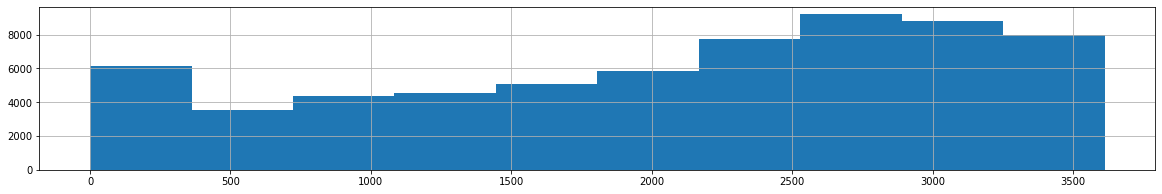

In [62]:
df['영업일수'].hist()

In [63]:
from sklearn.preprocessing import KBinsDiscretizer

In [64]:
df['영업일수_bin'] = KBinsDiscretizer(n_bins=10, encode='ordinal').fit_transform(df['영업일수'].values.reshape(-1,1))

In [65]:
import category_encoders as ce

In [66]:
# set up a weight of evidence encoder
df['영업일수_woe'] = df['영업일수_bin'].astype('category')
woe_encoder = ce.WOEEncoder('영업일수_woe')
# fit the encoder
woe_encoder.fit(df['영업일수_woe'], df['점검결과'])

WOEEncoder(cols=['영업일수_woe'], verbose='영업일수_woe')

In [67]:
df['영업일수_woe'] = woe_encoder.transform(df['영업일수_woe'])

In [68]:
df.head(2)

,ID,DBA Name,license,Facility Type,Risk,Address,Inspection Date,Results,Violations,Latitude,...,위반 (t-2),점검 (t-3),위반 (t-3),점검 (t-4),위반 (t-4),점검 (t-5),위반 (t-5),ft_tm,영업일수_bin,영업일수_woe
0,467259,"#1 CHINA EXPRESS, LTD.",1869616.0,Restaurant,3,4248 S WENTWORTH AVE,2010-11-29T00:00:00.000,0,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",0.457403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431,0.0,0.399939
1,276951,#1 CHOP SUEY,1970042.0,Restaurant,3,4307 W IRVING PARK RD,2010-06-28T00:00:00.000,0,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,0.820346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431,7.0,-0.145251


# 필요 없는 컬럼 삭제

In [69]:
df.columns

Index(['ID', 'DBA Name', 'license', 'Facility Type', 'Risk', 'Address',
       'Inspection Date', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Date', 'year', 'month', 'day', '점검결과', '영업일수', 'Restaurant',
       'previous_results', 'far', 'far_q', '점검', '위반', '점검 (t-1)', '위반 (t-1)',
       '점검 (t-2)', '위반 (t-2)', '점검 (t-3)', '위반 (t-3)', '점검 (t-4)', '위반 (t-4)',
       '점검 (t-5)', '위반 (t-5)', 'ft_tm', '영업일수_bin', '영업일수_woe'],
      dtype='object')

In [70]:
df = df.drop(['license', 'DBA Name', 'Address', 'Inspection Date', 'Results',
              'Violations', 'Latitude', 'Longitude', 'Date', 'day', 
              '점검', '위반',
              'previous_results'], axis = 1)

In [71]:
df.set_index('ID', inplace=True)
df.to_pickle('../data/chicago.pkl') # 중간 저장

In [72]:
df.head()
df.shape

,Facility Type,Risk,year,month,점검결과,영업일수,Restaurant,far,far_q,점검 (t-1),...,위반 (t-2),점검 (t-3),위반 (t-3),점검 (t-4),위반 (t-4),점검 (t-5),위반 (t-5),ft_tm,영업일수_bin,영업일수_woe
ID,,,,,,,,,,,,,,,,,,,,,
467259,Restaurant,3,2010,11,0,0,1,0.910054,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431,0.0,0.399939
276951,Restaurant,3,2010,6,0,2850,1,0.787037,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431,7.0,-0.145251
397260,Restaurant,3,2011,1,0,2850,1,0.787037,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431,7.0,-0.145251
1271460,Restaurant,3,2012,11,0,2850,1,0.787037,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431,7.0,-0.145251
1072233,Restaurant,3,2013,1,1,2850,1,0.722415,1,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.270431,7.0,-0.145251


(63113, 22)

In [73]:
pd.DataFrame({'자료형태':df.dtypes, '결측치수':df.isnull().sum(), '고유값수':df.nunique()})

,자료형태,결측치수,고유값수
Facility Type,category,0,8
Risk,int64,0,3
year,int64,0,10
month,int64,0,12
점검결과,int64,0,2
영업일수,int64,0,3198
Restaurant,int32,0,2
far,float64,0,12556
far_q,int32,0,5
점검 (t-1),float64,0,44


- 범주형데이터 변환

In [74]:
df['year'] = df['year'].astype('category')
df['month'] = df['month'].astype('category')
df['far_q'] = df['far_q'].astype('category')
df['영업일수_bin'] = df['영업일수_bin'].astype('category')

# 예측

In [75]:
# labelEncoder present in scikitlearn library 
from sklearn.preprocessing import LabelEncoder, StandardScaler 
le = LabelEncoder() 
df['Risk'] = le.fit_transform(df['Risk'])

In [76]:
categorical_list = df.select_dtypes(include=['category']).columns
tf = df.sample(frac=0.2)
tf.shape

(12623, 22)

In [77]:
tf.head()

,Facility Type,Risk,year,month,점검결과,영업일수,Restaurant,far,far_q,점검 (t-1),...,위반 (t-2),점검 (t-3),위반 (t-3),점검 (t-4),위반 (t-4),점검 (t-5),위반 (t-5),ft_tm,영업일수_bin,영업일수_woe
ID,,,,,,,,,,,,,,,,,,,,,
1114846,School,2,2013,5,0,1890,0,0.946332,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250655,3.0,-0.044432
2015332,Restaurant,2,2017,5,0,0,1,0.802892,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431,0.0,0.399939
2081307,Restaurant,2,2017,8,0,2794,1,0.720277,1,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.270431,6.0,-0.162859
409228,Restaurant,2,2010,8,1,2835,1,1.001847,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431,7.0,-0.145251
1955481,Restaurant,2,2017,1,0,644,1,1.003113,4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431,1.0,0.144433


In [78]:
from sklearn.model_selection import train_test_split
X = pd.get_dummies(tf.drop(['점검결과'], axis=1), prefix= categorical_list)
y = tf['점검결과']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y,
                                          random_state = 11)

In [79]:
# Model evaluation
from sklearn.model_selection import cross_val_score, KFold
#Model evaluation metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, recall_score, log_loss, brier_score_loss
from scipy.stats import ks_2samp

# 파이프라인
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold

# Classifiers

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [81]:
classifiers = {}
classifiers.update({'KNN': KNeighborsClassifier()})
classifiers.update({'GNB': GaussianNB()})
classifiers.update({'LGR': LogisticRegression(class_weight='balanced', random_state=11, solver ='liblinear')})
classifiers.update({'SVC': SVC(class_weight='balanced', probability=True, max_iter=300)})
classifiers.update({'Decisiontree': DecisionTreeClassifier()})
classifiers.update({'Random Forest': RandomForestClassifier(class_weight='balanced', 
                                                 n_estimators=300)})
classifiers.update({'Gradient Boosting': GradientBoostingClassifier()})

- RidgeClassifier()는 종속변수 y를 ‘1’과 ‘-1’로 변경하고 선형 최소제곱을 손실함수로 하여 로지스틱 회귀에 penalty 2(L2)를 적용한 모델이다. 
      * RidgeClassifier()는 다항 분류 예측일 경우에 로지스틱회귀보다 연산 속도가 빠르다. 

- Extra-Trees()는 랜덤포레스트 알고리즘과는 다르게 각 노드의 불순도를 줄이는 대신에 무작위 분류기준(random thresholds)을 설정한다. 
      * Extra-Trees() 분류기는 무작위성 트리(Extremely Randomized Trees)를 구성하여 분산을 줄이는 대가로 편향을 높게 하여 예측한다.

In [82]:
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import ExtraTreeClassifier

classifiers.update({'Ridge': RidgeClassifier()})
classifiers.update({'Extra Trees': ExtraTreeClassifier()})

classifiers

{'KNN': KNeighborsClassifier(),
 'GNB': GaussianNB(),
 'LGR': LogisticRegression(class_weight='balanced', random_state=11, solver='liblinear'),
 'SVC': SVC(class_weight='balanced', max_iter=300, probability=True),
 'Decisiontree': DecisionTreeClassifier(),
 'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=300),
 'Gradient Boosting': GradientBoostingClassifier(),
 'Ridge': RidgeClassifier(),
 'Extra Trees': ExtraTreeClassifier()}

- 예측 확률을 구하는 함수가 다른 ‘SVC’와 ‘Ridge’를 저장한다

In [83]:
DECISION_FUNCTIONS = {'SVC', 'Ridge'}

# Parameters

In [84]:
parameters = {}
parameters.update({'KNN': 
{ 
'classifier__n_neighbors': [1, 2, 3, 11, 17], 'classifier__weights': ['uniform','distance'],
'classifier__leaf_size': list(range(4,6))}
})

In [85]:
parameters.update({'GNB': {}})

In [86]:
parameters.update({'LGR': 
{ 
'classifier__C': [0.01, 0.1, 1, 10], 'classifier__penalty': ['l1', 'l2']}
})

In [87]:
parameters.update({'SVC': 
{ 
'classifier__kernel': ['linear', 'rbf', 'poly'],
'classifier__gamma': ['auto'],
'classifier__C': [0.1, 0.5, 1, 5, 10, 50, 100],
'classifier__degree': [1, 2, 3, 4, 5, 6]
}})

In [88]:
parameters.update({'Decisiontree': 
{ 
'classifier__criterion' :['gini', 'entropy'],
'classifier__splitter': ['best', 'random'],
'classifier__class_weight': [None, 'balanced'],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__max_depth' : [1,2,3, 4, 5, 6, 7, 8],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
}})

In [89]:
parameters.update({'Random Forest': 
{ 
'classifier__n_estimators': [200],
'classifier__class_weight': [None, 'balanced'],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__max_depth' : [3, 4, 5, 6, 7, 8],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
'classifier__criterion' :['gini', 'entropy']     ,
'classifier__n_jobs': [-1]
}})

In [90]:
parameters.update({'Gradient Boosting': 
{ 
'classifier__learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
'classifier__n_estimators': [200],
'classifier__max_depth': [2,3,4,5,6],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__subsample': [0.8, 0.9, 1]
}})

In [91]:
parameters.update({'Ridge': 
{ 
'classifier__alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
}})

In [92]:
parameters.update({'Extra Trees': 
{ 
'classifier__criterion' :['gini', 'entropy'],
'classifier__splitter': ['best', 'random'],
'classifier__class_weight': [None, 'balanced'],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__max_depth' : [1,2,3, 4, 5, 6, 7, 8],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
}})

In [93]:
from tqdm import tqdm_notebook
from joblib import dump, load
kf = KFold(n_splits=2)

In [94]:
results = {}

for classifier_label, classifier in tqdm_notebook(classifiers.items()):
    steps = [('classifier', classifier)] # 표준화는 생략 시간절약을 위해
    #steps = [('scaler', StandardScaler()), ('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = parameters[classifier_label]
    
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,  n_iter = 3,
                            scoring = 'recall')    


    y_pred = gs.fit(X_train, y_train).predict(X_test)
    
    if classifier_label in DECISION_FUNCTIONS:
        y_proba = gs.decision_function(X_test)
        ap = average_precision_score(y_test, y_proba)
        
    else:
        y_proba = gs.predict_proba(X_test)[:,1]
        ap = average_precision_score(y_test, y_proba)
   
    result = {'Best Parameters': gs.best_params_,
              'Training recall_macro': gs.best_score_,
              'AUROC': roc_auc_score(y_test, y_proba),
              'Average PR': ap,
              'F1-score': f1_score(y_test, y_pred),
              'CV accuracy': cross_val_score(gs, X_train, y_train).mean(),
              'Log_loss': log_loss(y_test, y_proba),
             }
    
    results.update({classifier_label: result})
    
    dump(gs.best_estimator_, f'../output/chicago_{classifier_label}.joblib')
    
    print(classification_report(y_test, y_pred))

['../output/chicago_KNN.joblib']

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1835
           1       0.35      0.33      0.34       690

    accuracy                           0.65      2525
   macro avg       0.55      0.55      0.55      2525
weighted avg       0.64      0.65      0.65      2525



['../output/chicago_GNB.joblib']

              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1835
           1       0.36      0.48      0.41       690

    accuracy                           0.63      2525
   macro avg       0.57      0.58      0.57      2525
weighted avg       0.67      0.63      0.64      2525



['../output/chicago_LGR.joblib']

              precision    recall  f1-score   support

           0       0.79      0.63      0.70      1835
           1       0.36      0.55      0.43       690

    accuracy                           0.61      2525
   macro avg       0.57      0.59      0.57      2525
weighted avg       0.67      0.61      0.63      2525



['../output/chicago_SVC.joblib']

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1835
           1       0.27      1.00      0.43       690

    accuracy                           0.27      2525
   macro avg       0.64      0.50      0.22      2525
weighted avg       0.80      0.27      0.12      2525



['../output/chicago_Decisiontree.joblib']

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1835
           1       0.33      0.23      0.27       690

    accuracy                           0.66      2525
   macro avg       0.53      0.52      0.52      2525
weighted avg       0.63      0.66      0.64      2525



['../output/chicago_Random Forest.joblib']

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1835
           1       0.00      0.00      0.00       690

    accuracy                           0.73      2525
   macro avg       0.36      0.50      0.42      2525
weighted avg       0.53      0.73      0.61      2525



['../output/chicago_Gradient Boosting.joblib']

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1835
           1       0.45      0.03      0.05       690

    accuracy                           0.73      2525
   macro avg       0.59      0.51      0.45      2525
weighted avg       0.65      0.73      0.62      2525



['../output/chicago_Ridge.joblib']

              precision    recall  f1-score   support

           0       0.75      0.97      0.84      1835
           1       0.62      0.12      0.20       690

    accuracy                           0.74      2525
   macro avg       0.68      0.55      0.52      2525
weighted avg       0.71      0.74      0.67      2525



['../output/chicago_Extra Trees.joblib']

              precision    recall  f1-score   support

           0       0.76      0.36      0.49      1835
           1       0.29      0.70      0.41       690

    accuracy                           0.46      2525
   macro avg       0.53      0.53      0.45      2525
weighted avg       0.63      0.46      0.47      2525




In [95]:
pd.DataFrame(results).T.sort_values(by = 'F1-score', ascending=False)

,Best Parameters,Training recall_macro,AUROC,Average PR,F1-score,CV accuracy,Log_loss
LGR,"{'classifier__penalty': 'l2', 'classifier__C':...",0.568812,0.630872,0.403255,0.432648,0.555072,0.666269
SVC,"{'classifier__kernel': 'rbf', 'classifier__gam...",0.518389,0.516256,0.289086,0.429371,0.444203,0.958276
GNB,{},0.543177,0.616462,0.394993,0.414741,0.485145,1.560788
Extra Trees,"{'classifier__splitter': 'best', 'classifier__...",0.51685,0.544657,0.301238,0.412318,0.481522,0.690722
KNN,"{'classifier__weights': 'distance', 'classifie...",0.287631,0.551501,0.29968,0.342046,0.271739,12.051088
Decisiontree,"{'classifier__splitter': 'random', 'classifier...",0.645855,0.52603,0.287971,0.26769,0.182971,0.69
Ridge,{'classifier__alpha': 1e-06},0.094551,0.630906,0.415418,0.19732,0.097464,8.398159
Gradient Boosting,"{'classifier__subsample': 0.8, 'classifier__n_...",0.048208,0.606609,0.364727,0.051913,0.068478,0.573449
Random Forest,"{'classifier__n_jobs': -1, 'classifier__n_esti...",0.0,0.606511,0.355478,0.0,0.555435,0.578294


In [96]:
import glob
glob.glob('../output/chi*.joblib')

['../output\\chicago_Decisiontree.joblib',
 '../output\\chicago_Extra Trees.joblib',
 '../output\\chicago_GNB.joblib',
 '../output\\chicago_Gradient Boosting.joblib',
 '../output\\chicago_KNN.joblib',
 '../output\\chicago_LGR.joblib',
 '../output\\chicago_Random Forest.joblib',
 '../output\\chicago_Ridge.joblib',
 '../output\\chicago_SVC.joblib']

# 보정 곡선(Calibration plot)
- 보정 곡선은 모델의 예측값을 기준으로 10분위 구간 (0%, 10%, 20%, … 90, 100%)의 구간으로 예측 확률과 실제 비율의 관계를 나타낸다
- 빈 리스트 형태의 변수를 생성한 후 반복문을 통해 모든 모델의 key와 values를 하나씩 읽어와 예측 확률과 모델명을 기록한다. 
- No hyperparameter tunning

In [97]:
classifier_labels = []
probas_list = []
for classifier_label, classifier in classifiers.items():
    steps = [('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = {}   
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                          n_iter = 2, scoring = 'f1_micro')  
    
    if classifier_label in DECISION_FUNCTIONS:
        y_proba = gs.fit(X_train, y_train).decision_function(X_test)
    else:
        y_proba = gs.fit(X_train, y_train).predict_proba(X_test)
       
    probas_list.append(y_proba)
    classifier_labels.append(classifier_label)

- 모델명과 예측 확률로 skplt.metrics.plot() 함수를 사용하여 보정 곡선을 확인한다. 
- 45 도선을(Perfectly calibrated) 따라가면 예측 확률이 균등하게 분포된 형태로 신뢰구간과 같은 역할을 한다

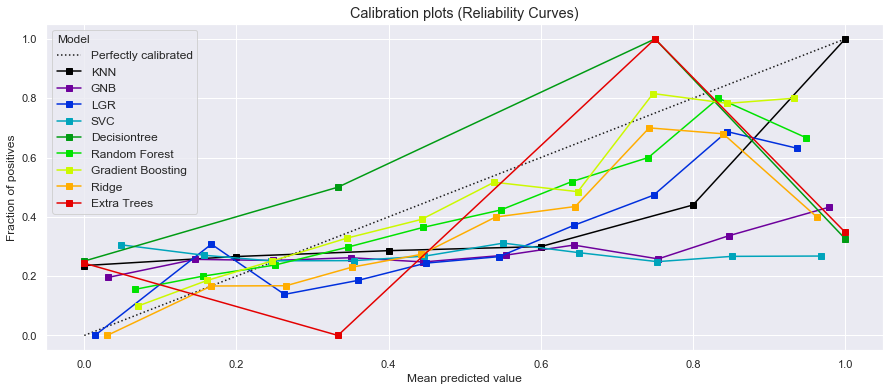

In [98]:
import scikitplot as skplt
sns.set()
skplt.metrics.plot_calibration_curve(y_test, probas_list, classifier_labels, figsize=(15,6))
leg = plt.legend(title='Model', fontsize = 12)
leg._legend_box.align = 'left'

# Random Forest

In [111]:
grid = {
'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
'max_features': ['auto', 'sqrt'],
'max_depth': [int(x) for x in np.linspace(5, 20, 10)],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'bootstrap': [True, False]
}

In [112]:
np.random.seed(1357)
kf = KFold(n_splits=5)
rf = RandomForestClassifier(random_state=11, class_weight='balanced')
rf_random = RandomizedSearchCV(estimator= rf, 
                               param_distributions = grid, cv=kf)
y_predict = rf_random.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict))

0.6768316831683169

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1835
           1       0.40      0.38      0.39       690

    accuracy                           0.68      2525
   macro avg       0.59      0.59      0.59      2525
weighted avg       0.67      0.68      0.67      2525



ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000279A38E06C8>,
       classes=['Not_buy', 'Buy'], model=None)

0.6363910085704856

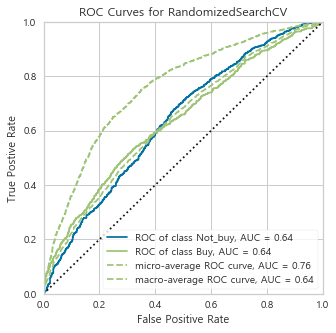

In [125]:
from yellowbrick.classifier import ROCAUC
plt.rcParams["figure.figsize"] = (5,5)
visualizer = ROCAUC(rf_random, classes=['Not_buy', 'Buy'])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

FeatureImportances(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002798E96F408>,
                   model=None)

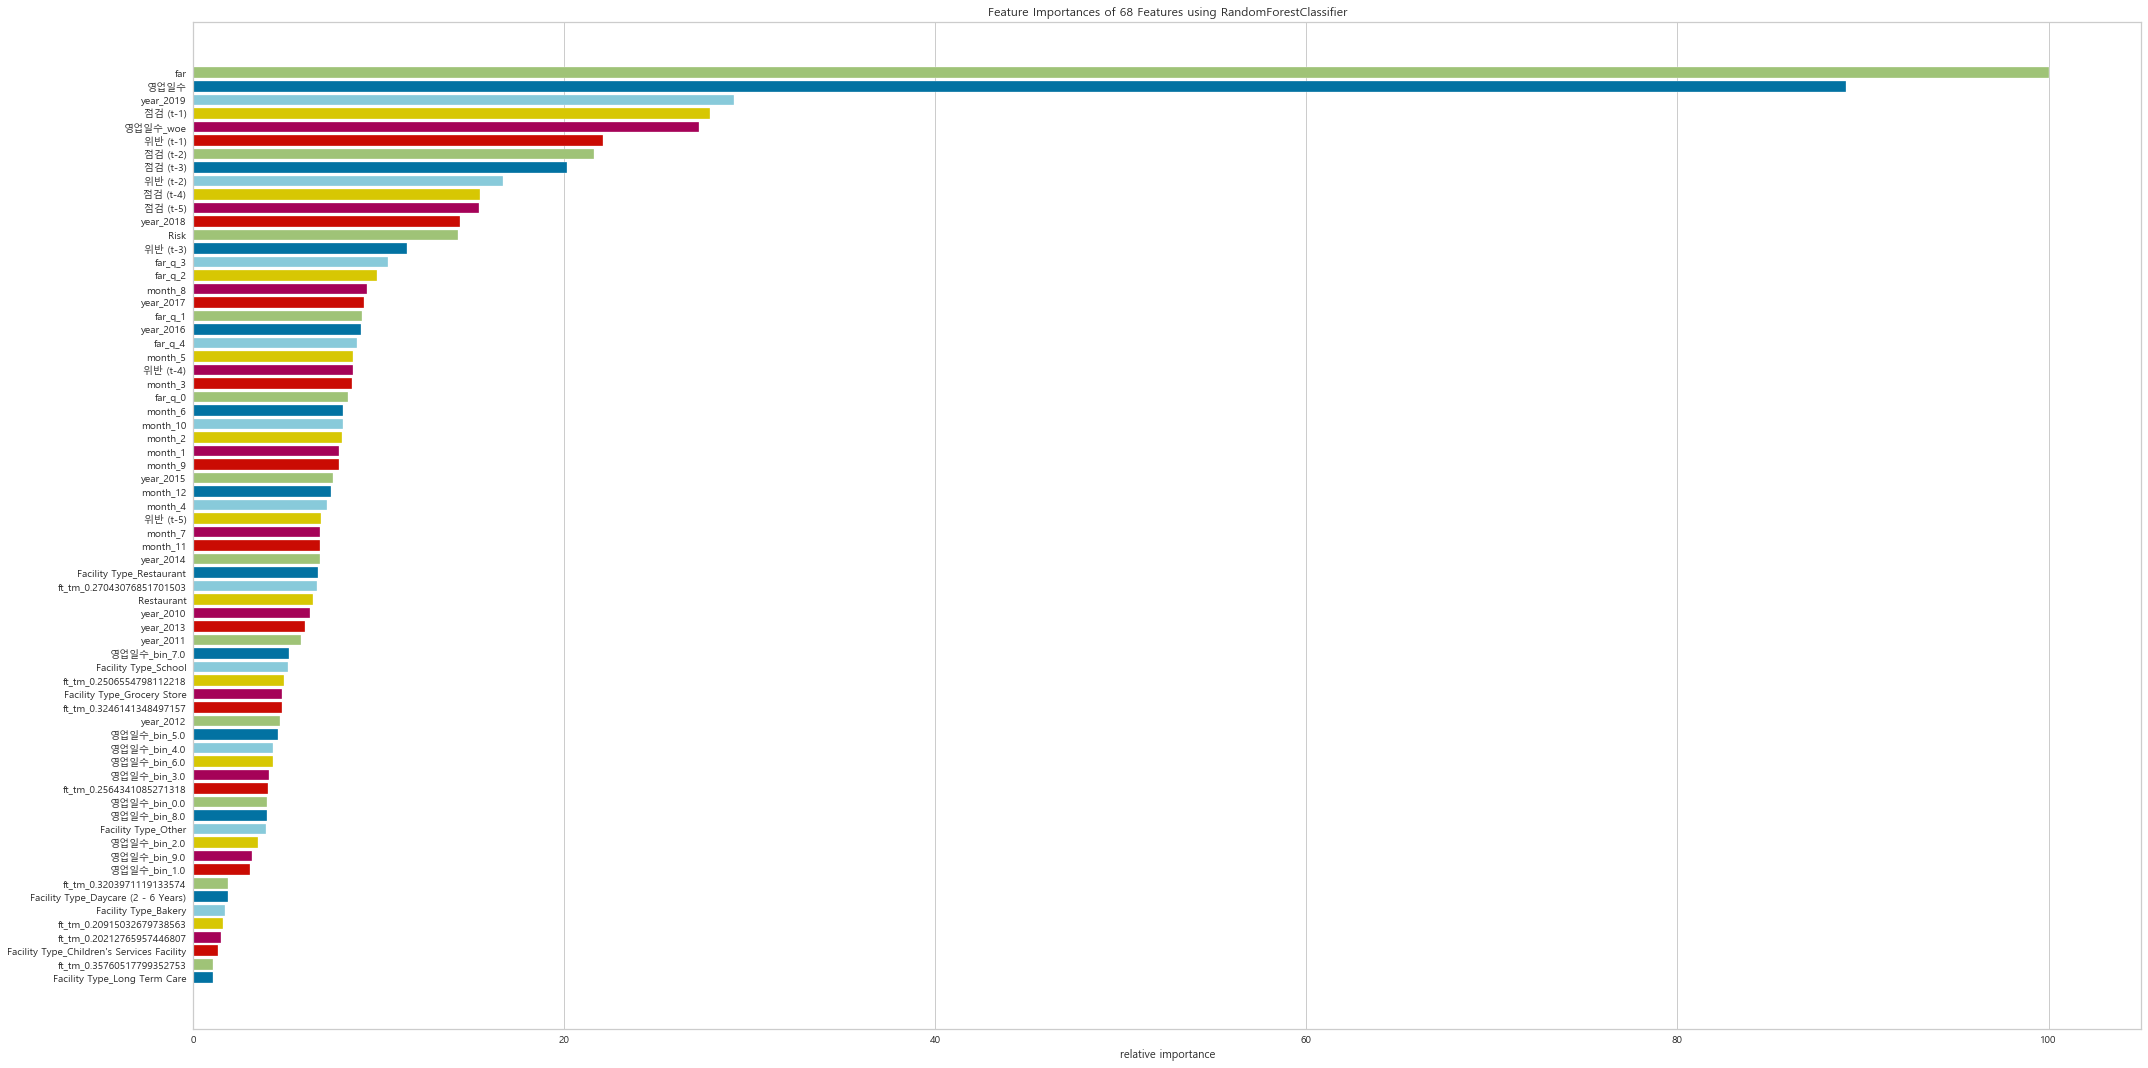

In [114]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['font.family']='Malgun Gothic'
viz = FeatureImportances(rf_random.best_estimator_)
viz.fit(X_train, y_train)
viz.show()

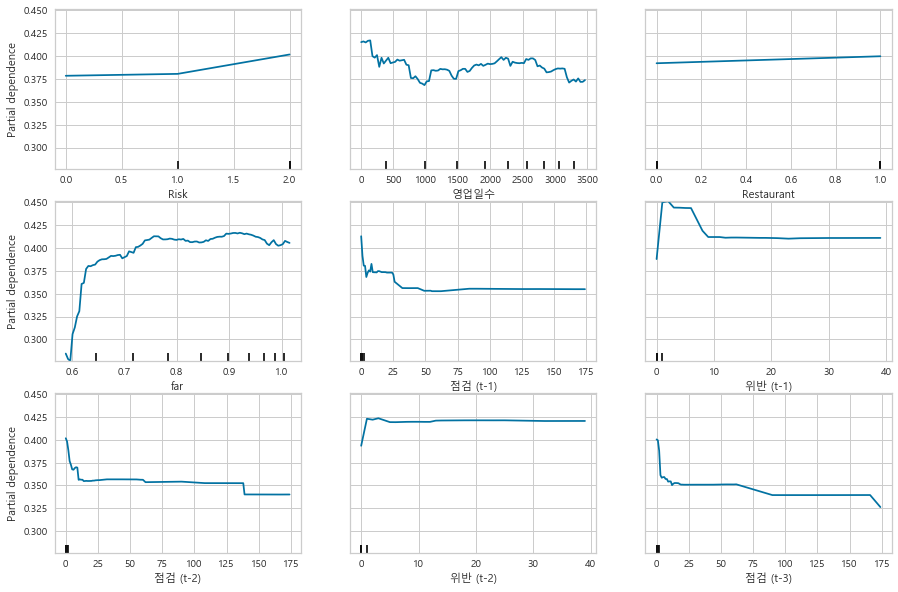

In [126]:
from sklearn.inspection import plot_partial_dependence
plt.rcParams["figure.figsize"] = (15,10)
features = X_train.columns[0:9]
plot_partial_dependence(rf_random.best_estimator_, X_train, features) 
fig.subplots_adjust(hspace=5)

DiscriminationThreshold(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000279A2DAF748>,
                        force_model=None, model=None)

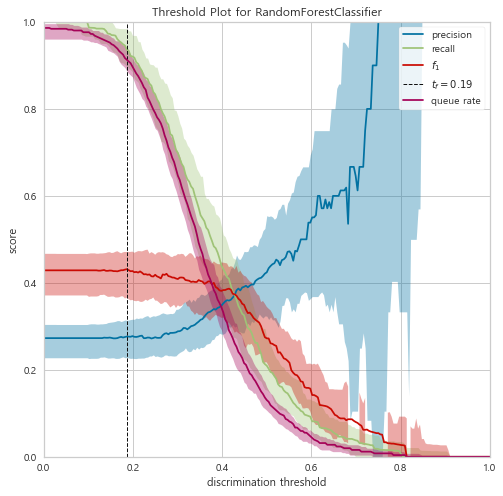

In [123]:
from yellowbrick.classifier import DiscriminationThreshold
plt.rcParams["figure.figsize"] = (8,8)
visualizer = DiscriminationThreshold(rf_random.best_estimator_)
visualizer.fit(X_test, y_test)  # Fit the training data to the visualizer
visualizer.poof()

# 과적합을 줄이는 방법 (How to reduce overfitting?)
## 1. Cross validation__Data 측면
## 2. Regularization(Shrinkage, penalty)__손실함수 측면
## 3. Ensemble__알고리즘 측면

# 교차검증의 종류
https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

In [117]:
from sklearn.model_selection import (KFold, StratifiedKFold, GroupKFold)
kf = KFold(n_splits=5)
for train, test in kf.split(X_train):
    print("%s %s" % (train, test))

[ 2020  2021  2022 ... 10095 10096 10097] [   0    1    2 ... 2017 2018 2019]
[    0     1     2 ... 10095 10096 10097] [2020 2021 2022 ... 4037 4038 4039]
[    0     1     2 ... 10095 10096 10097] [4040 4041 4042 ... 6057 6058 6059]
[    0     1     2 ... 10095 10096 10097] [6060 6061 6062 ... 8076 8077 8078]
[   0    1    2 ... 8076 8077 8078] [ 8079  8080  8081 ... 10095 10096 10097]


In [118]:
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
skf
for train_index, test_index in skf.split(X, y):
    print("%s %s" % (train_index, test_index))

StratifiedKFold(n_splits=5, random_state=11, shuffle=True)

[    0     1     2 ... 12620 12621 12622] [   14    16    17 ... 12610 12615 12616]
[    0     1     3 ... 12620 12621 12622] [    2     4    11 ... 12598 12612 12617]
[    0     1     2 ... 12616 12617 12619] [    8    15    34 ... 12620 12621 12622]
[    0     2     3 ... 12620 12621 12622] [    1     7    12 ... 12608 12614 12619]
[    1     2     4 ... 12620 12621 12622] [    0     3     5 ... 12606 12611 12613]


In [119]:
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
rf_random = RandomizedSearchCV(estimator= rf, param_distributions = grid,
                                  cv=skf)
rf_random.fit(X_train, y_train)
y_predict = rf_random.predict(X_test)
accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict))

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=11),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 6, 8, 10, 11, 13, 15,
                                                      16, 18, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]})

0.6974257425742574

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1835
           1       0.43      0.33      0.37       690

    accuracy                           0.70      2525
   macro avg       0.60      0.58      0.59      2525
weighted avg       0.68      0.70      0.68      2525



# End